## Stochastic Gradient Descent (SGD)

We are **minimizing** an objective function, thus descending

A few types of gradient descent are the following:

* Stochastic Gradient Descent, **SGD** - *fits a single sample at a time*
* Batch Gradient Descent, **BGD** - *fits the whole dataset at once*
* Mini-Batch Gradient Descent, **MBGD** - *fits slices of the dataset*

We update the weights and biases, subtracting from it the respective **calculated gradients * learning rate** <br> $updtweights = -\nabla weights * learningrate$ <br>
$updtbiases = -\nabla biases * learningrate$ <br>

We use a **learning rate** of 1 at the moment - however as it is a hyperparameter - we will adjust this rate later on

In [1]:
%%capture 
# we hide the output of the cell
# we simply import the previous chapter
%run -i Chapter_8B_All_Code.ipynb

In [2]:
# SGD optimizer
class Optimizer_SGD:
    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1.0):
        self.learning_rate = learning_rate
    # Update parameters
    def update_params(self, layer):
        layer.weights += -self.learning_rate * layer.dweights
        layer.biases += -self.learning_rate * layer.dbiases

In [3]:
# Create dataset
X, y = spiral_data(samples=100, classes=3)
# Create Dense layer with 2 input FEATURES (64 NEURONS) and 64 output values
dense1 = Layer_Dense(2, 64)
# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()
# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_SGD()

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
        f'acc: {accuracy:.3f}, ' +
        f'loss: {loss:.3f}')
    
    # !!! Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # !!! Update weights and biases (our gradient)
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)


epoch: 0, acc: 0.347, loss: 1.099
epoch: 100, acc: 0.407, loss: 1.070
epoch: 200, acc: 0.410, loss: 1.064
epoch: 300, acc: 0.427, loss: 1.061
epoch: 400, acc: 0.420, loss: 1.059
epoch: 500, acc: 0.420, loss: 1.056
epoch: 600, acc: 0.420, loss: 1.052
epoch: 700, acc: 0.433, loss: 1.043
epoch: 800, acc: 0.453, loss: 1.029
epoch: 900, acc: 0.503, loss: 1.014
epoch: 1000, acc: 0.450, loss: 1.018
epoch: 1100, acc: 0.460, loss: 1.013
epoch: 1200, acc: 0.437, loss: 1.007
epoch: 1300, acc: 0.453, loss: 1.005
epoch: 1400, acc: 0.420, loss: 1.002
epoch: 1500, acc: 0.450, loss: 0.990
epoch: 1600, acc: 0.443, loss: 0.996
epoch: 1700, acc: 0.487, loss: 0.983
epoch: 1800, acc: 0.470, loss: 0.972
epoch: 1900, acc: 0.473, loss: 0.964
epoch: 2000, acc: 0.500, loss: 0.952
epoch: 2100, acc: 0.490, loss: 0.945
epoch: 2200, acc: 0.517, loss: 0.943
epoch: 2300, acc: 0.517, loss: 0.925
epoch: 2400, acc: 0.533, loss: 0.923
epoch: 2500, acc: 0.520, loss: 0.908
epoch: 2600, acc: 0.537, loss: 0.900
epoch: 2700, 

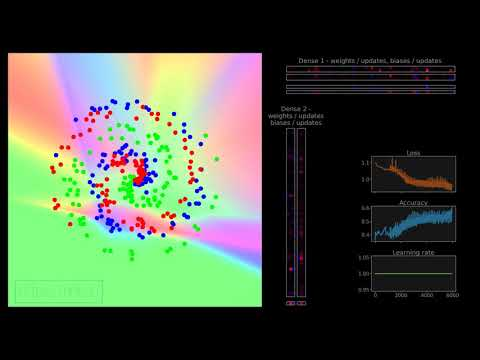

In [4]:
from IPython.display import YouTubeVideo
YouTubeVideo('Ge9d_8Bq_q8', width=800, height=600)

## Learning Rate

More **epochs - (a full forward and backward pass)** do not optimize our model - we are stuck in a local minimum. We need to adjust our learning rate 

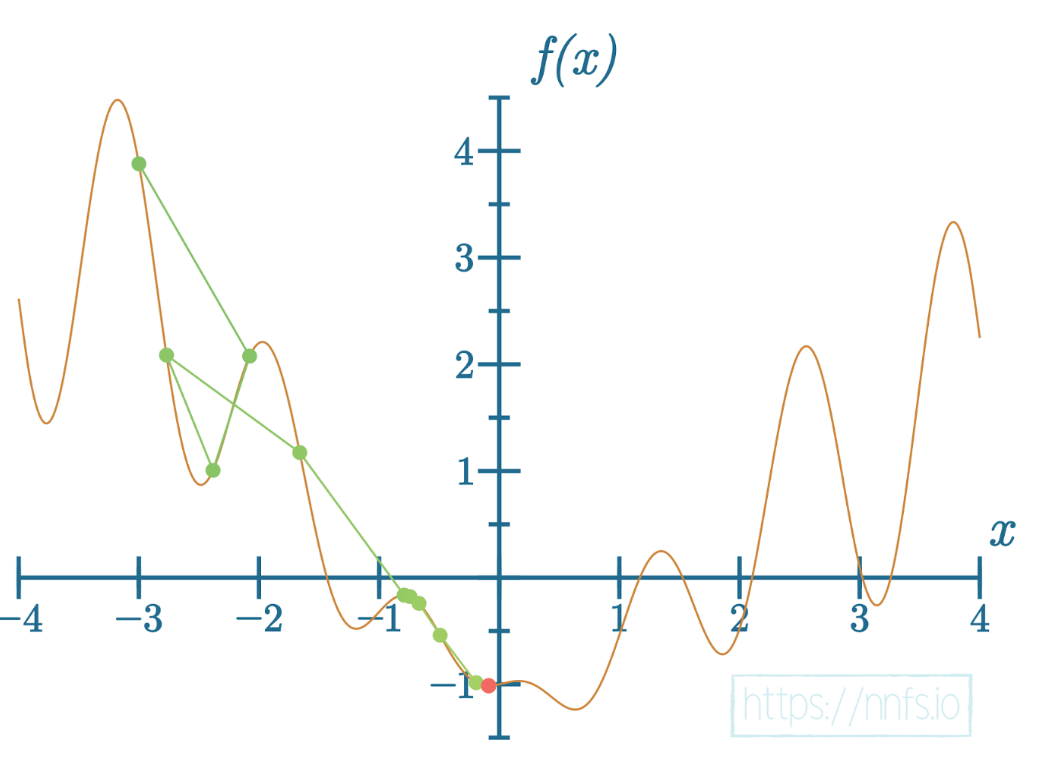

While the **learning rate** can be adjusted and tried out several times - it often gets stuck in local minima, therefore a dynamic way to adjust the rate of learning is used

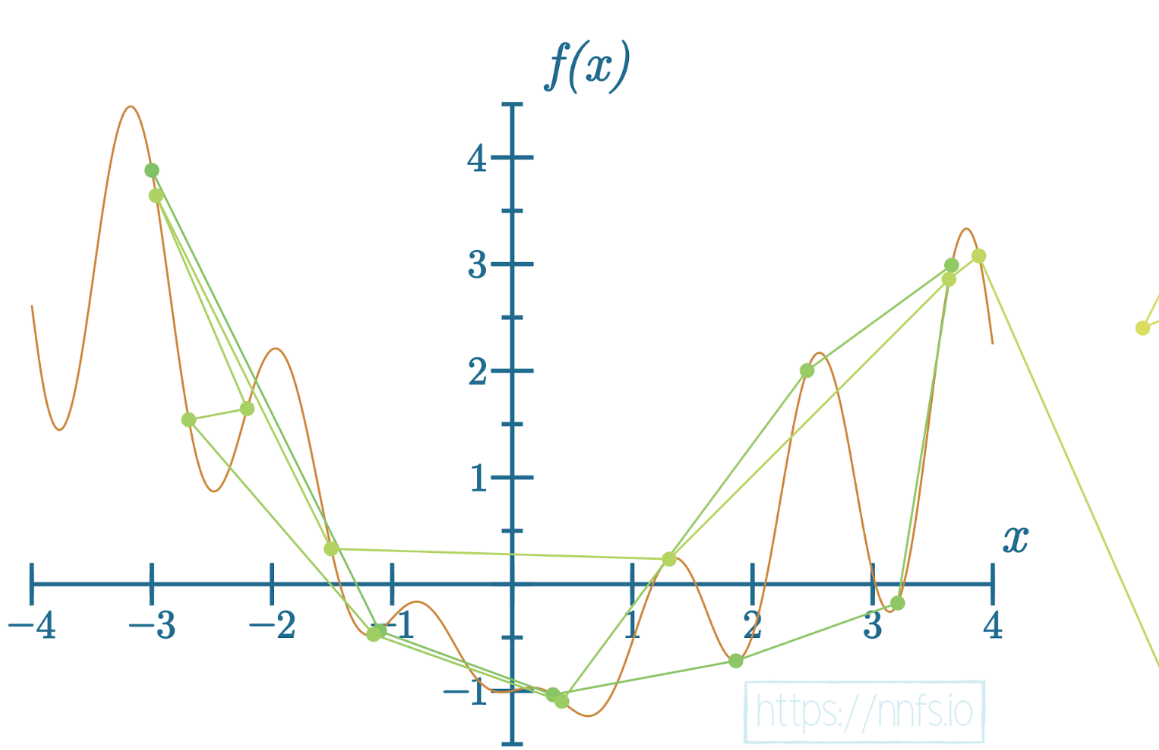

When the learning rate is **too large** we have a **gradient explosion** this causes an overflow, since floating point numbers become too big - the network failed to train.

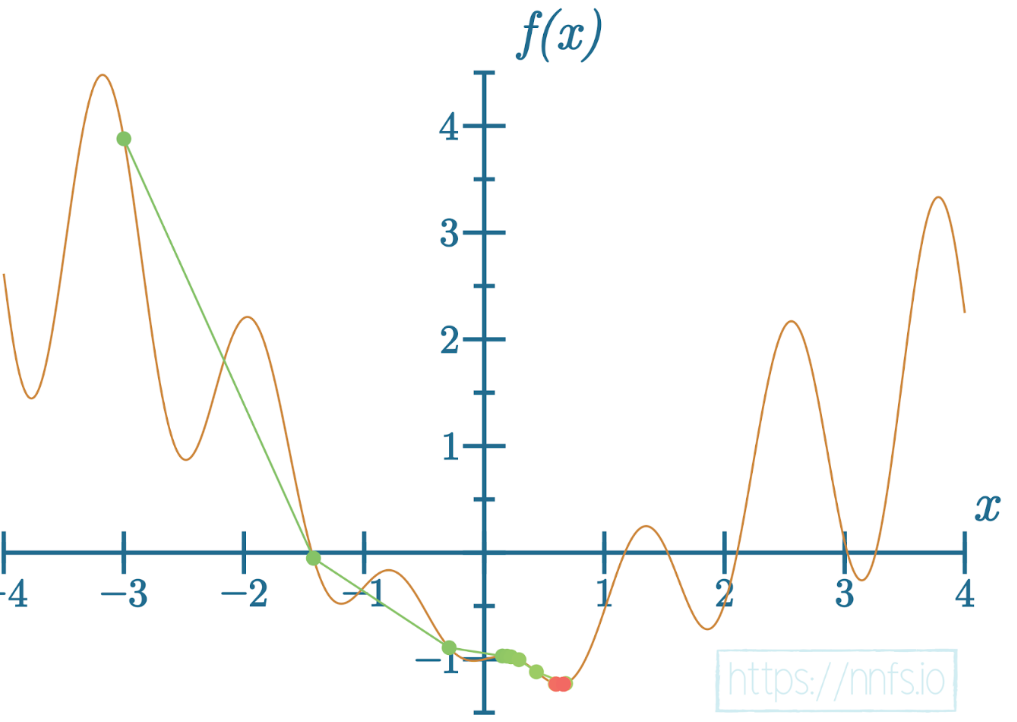

It is thus crucially important to find a good learning rate:
* **too small** -> too many steps to find the minima
* **too big** -> overshooting the minima or explosion (everything breaks)
to find the right parameters however is important therefore we introduce a dynamic method of setting the rate of learning, where we seek to make large steps at the beginning, while taking smaller steps later on.

## Stochastic Gradient Descent with Momentum

One such method is to calculate the learning rate as a rolling average of gradients. This has the effect of a **momentum**. That means downhill speeds the learning rate up, this momentum then can be used to *escape* local minima. <br>
With the momentum we will retain a certain direction and influence from a previous step to the current one.

In [5]:
# SGD optimizer
class Optimizer_SGD:
    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
        
    # call once before any parameters updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                                         (1. / (1. + self.decay * self.iterations))
        
    # Update parameters
    def update_params(self, layer):
        
        # if we use momentum for gradient descent
        if self.momentum:

            if not hasattr(layer, 'weight_momentums'):
                # if the layer does not have momentums yet we create them for the layer.
                # in the shape of the derived (gradient) of weights and biases
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
                
            # Build weight updates with momentum - take previous updates multiplied by retain factor (weight_momentums)
            # update with current gradients
            weight_updates = self.momentum * layer.weight_momentums - \
                             self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
            
            bias_updates = self.momentum * layer.bias_momentums - \
                             self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
            
        else:
            # vanilla SGD updates (fixed learning rate)
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases
            
        
        layer.weights += weight_updates
        layer.biases += bias_updates
        
    # called onced after any param updates
    def post_update_params(self):
        self.iterations += 1
        

In [7]:
# Create dataset
X, y = spiral_data(samples=100, classes=3)
# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)
# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()
# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
# Create optimizer
optimizer = Optimizer_SGD(decay=1e-3, momentum=0.9)
# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
        accuracy = np.mean(predictions==y)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
            f'acc: {accuracy:.3f}, ' +
            f'loss: {loss:.3f}, ' +
            f'lr: {optimizer.current_learning_rate}')
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

epoch: 0, acc: 0.723, loss: 1.099, lr: 1.0
epoch: 100, acc: 0.723, loss: 1.042, lr: 0.9099181073703367
epoch: 200, acc: 0.723, loss: 0.949, lr: 0.8340283569641367
epoch: 300, acc: 0.723, loss: 0.828, lr: 0.7698229407236336
epoch: 400, acc: 0.723, loss: 0.700, lr: 0.7147962830593281
epoch: 500, acc: 0.723, loss: 0.598, lr: 0.66711140760507
epoch: 600, acc: 0.723, loss: 0.555, lr: 0.6253908692933083
epoch: 700, acc: 0.723, loss: 0.531, lr: 0.5885815185403178
epoch: 800, acc: 0.723, loss: 0.516, lr: 0.5558643690939411
epoch: 900, acc: 0.723, loss: 0.506, lr: 0.526592943654555
epoch: 1000, acc: 0.723, loss: 0.500, lr: 0.5002501250625312
epoch: 1100, acc: 0.723, loss: 0.495, lr: 0.4764173415912339
epoch: 1200, acc: 0.723, loss: 0.491, lr: 0.45475216007276037
epoch: 1300, acc: 0.723, loss: 0.487, lr: 0.43497172683775553
epoch: 1400, acc: 0.723, loss: 0.485, lr: 0.4168403501458941
epoch: 1500, acc: 0.723, loss: 0.483, lr: 0.4001600640256102
epoch: 1600, acc: 0.723, loss: 0.480, lr: 0.38476337

## Ada Grad